In [1]:
# %pip install -U -r requirements.txt

In [2]:
%load_ext watermark
%watermark -i -h -m -v -p numpy,MotionClouds,manim,pandas,matplotlib,scipy

Python implementation: CPython
Python version       : 3.9.21
IPython version      : 8.18.1

numpy       : 1.26.4
MotionClouds: 20220927
manim       : 0.18.1
pandas      : 2.2.3
matplotlib  : 3.9.4
scipy       : 1.13.1

Compiler    : Clang 16.0.0 (clang-1600.0.26.4)
OS          : Darwin
Release     : 24.3.0
Machine     : x86_64
Processor   : i386
CPU cores   : 36
Architecture: 64bit

Hostname: Ahsoka



# experiment 1 (aka pilot): one B_sf / some B_thetas / many thetas

In [3]:
# %rm -fr img_pilot

In [4]:
import os
import pandas as pd
import numpy as np

data_folder = 'img_pilot'

if not(os.path.isfile(f'{data_folder}/parameters.json')):
    os.makedirs(data_folder, exist_ok=True)

    print('\n Initializing')

    # parameters 
    import MotionClouds as mc

    N_B_theta = 9
    N_B_sf = 1
    N_repet = 2
    N_thetas = 12

    B_thetas = np.pi/3 * np.linspace(0, 1, N_B_theta+1)[1:]
    print('B_thetas = ', B_thetas)
    B_sfs = [mc.B_sf] #* np.logspace(-1, -1, N_B_sf, base=2)
    print('B_sfs = ', B_sfs)
    theta_max = np.pi/8
    thetas = np.linspace(-theta_max, theta_max, N_thetas)

    parameters = pd.DataFrame(columns=['i_trial', 'theta', 'B_theta', 'B_sf', 'seed', 'fname'])
    # generate all clouds
    import imageio
    def generate_random_cloud(i_trial, theta, B_theta, B_sf, seed, downscale = 1):
        # fname = f'{data_folder}/theta_{theta}_B_theta_{B_theta}_B_sf_{B_sf}_seed_{seed}.png'
        fname = f'{data_folder}/{i_trial}.png'
        if not os.path.isfile(fname):
            fx, fy, ft = mc.get_grids(mc.N_X/downscale, mc.N_Y/downscale, 1)
            mc_i = mc.envelope_gabor(fx, fy, ft, V_X=0., V_Y=0., B_sf=B_sf,
                                    B_V=0, theta=np.pi/2-theta, B_theta=B_theta)
            im = mc.random_cloud(mc_i, seed=seed)
            im = (mc.rectif(im) * 255).astype('uint8')
            imageio.imwrite(fname, im[:, :, 0])
        return fname


    all_conditions = [(i_repet, i_theta, i_B_theta, i_B_sf) 
                    for i_repet in range(N_repet) 
                    for i_theta in range(N_thetas) 
                    for i_B_theta in range(N_B_theta) 
                    for i_B_sf in range(N_B_sf)]
    N_total_trials = len(all_conditions)
    ind = np.random.permutation(N_total_trials)

    seed = 2024
    np.random.seed(seed)
    # parameters = []
    for i_trial in range(N_total_trials):
        i_repet, i_theta, i_B_theta, i_B_sf = all_conditions[ind[i_trial]]

        fname = generate_random_cloud(i_trial, thetas[i_theta], 
                                B_theta=B_thetas[i_B_theta], 
                                B_sf=B_sfs[i_B_sf], 
                                seed=seed+i_trial)
        # parameters.append({'fname':fname, 'theta': thetas[i_theta], 'B_theta': B_thetas[i_B_theta], 'B_sf': B_sfs[i_B_sf], 'seed': seed+i_trial, 'i_trial': i_trial})
        parameters.loc[i_trial] = [i_trial, thetas[i_theta], B_thetas[i_B_theta], B_sfs[i_B_sf], seed+i_trial, fname]
        print(f"          {{stimulus: '{fname}', on_finish: function() {{jsPsych.setProgressBar({i_trial/N_total_trials:.4f});}}}},",

    )

    parameters.to_json(f'{data_folder}/parameters.json')
    # import json
    # with open(f'{data_folder}/parameters.json', 'w') as f:
    #     json.dump(parameters, f)
else:
    parameters = pd.read_json(f'{data_folder}/parameters.json')
parameters


,fname,theta,B_theta,B_sf,seed,i_trial
0,img_pilot_folder/0.png,0.392699,0.116355,0.1,2024,0
1,img_pilot_folder/1.png,-0.249899,0.465421,0.1,2025,1
2,img_pilot_folder/2.png,-0.107100,1.047198,0.1,2026,2
3,img_pilot_folder/3.png,0.321299,0.698132,0.1,2027,3
4,img_pilot_folder/4.png,0.178500,0.581776,0.1,2028,4
...,...,...,...,...,...,...
211,img_pilot_folder/211.png,0.178500,0.698132,0.1,2235,211
212,img_pilot_folder/212.png,-0.392699,1.047198,0.1,2236,212
213,img_pilot_folder/213.png,-0.178500,0.581776,0.1,2237,213
214,img_pilot_folder/214.png,-0.392699,0.349066,0.1,2238,214


In [5]:
import os
import numpy as np

data_folder = 'img_pilot'

if True: #not(os.path.isfile(f'{data_folder}/parameters.json')):
    os.makedirs(data_folder, exist_ok=True)

    print('\n Initializing')

    # parameters 
    import MotionClouds as mc

    N_B_theta = 9
    N_B_sf = 1
    N_repet = 2
    N_thetas = 12

    B_thetas = np.pi/3 * np.linspace(0, 1, N_B_theta+1)[1:]
    print('B_thetas = ', B_thetas)
    B_sfs = [mc.B_sf] #* np.logspace(-1, -1, N_B_sf, base=2)
    print('B_sfs = ', B_sfs)
    theta_max = np.pi/8
    thetas = np.linspace(-theta_max, theta_max, N_thetas)

    # parameters = pd.DataFrame(columns=['i_trial', 'theta', 'B_theta', 'B_sf', 'seed', 'fname'])
    # generate all clouds
    # import imageio
    def generate_random_cloud(i_trial, theta, B_theta, B_sf, seed, downscale = 1):
        # fname = f'{data_folder}/theta_{theta}_B_theta_{B_theta}_B_sf_{B_sf}_seed_{seed}.png'
        fname = f'{data_folder}/{i_trial}.png'
        # if not os.path.isfile(fname):
        #     fx, fy, ft = mc.get_grids(mc.N_X/downscale, mc.N_Y/downscale, 1)
        #     mc_i = mc.envelope_gabor(fx, fy, ft, V_X=0., V_Y=0., B_sf=B_sf,
        #                             B_V=0, theta=np.pi/2-theta, B_theta=B_theta)
        #     im = mc.random_cloud(mc_i, seed=seed)
        #     im = (mc.rectif(im) * 255).astype('uint8')
        #     imageio.imwrite(fname, im[:, :, 0])
        return fname


    all_conditions = [(i_repet, i_theta, i_B_theta, i_B_sf) 
                    for i_repet in range(N_repet) 
                    for i_theta in range(N_thetas) 
                    for i_B_theta in range(N_B_theta) 
                    for i_B_sf in range(N_B_sf)]
    N_total_trials = len(all_conditions)
    ind = np.random.permutation(N_total_trials)

    seed = 2024
    np.random.seed(seed)
    # parameters = []
    for i_trial in range(N_total_trials):
        i_repet, i_theta, i_B_theta, i_B_sf = all_conditions[ind[i_trial]]

        fname = generate_random_cloud(i_trial, thetas[i_theta], 
                                B_theta=B_thetas[i_B_theta], 
                                B_sf=B_sfs[i_B_sf], 
                                seed=seed+i_trial)
        # parameters.append({'fname':fname, 'theta': thetas[i_theta], 'B_theta': B_thetas[i_B_theta], 'B_sf': B_sfs[i_B_sf], 'seed': seed+i_trial, 'i_trial': i_trial})
        # parameters.loc[i_trial] = [i_trial, thetas[i_theta], B_thetas[i_B_theta], B_sfs[i_B_sf], seed+i_trial, fname]
        print(f"          {{stimulus: '{fname}', on_finish: function() {{jsPsych.setProgressBar({i_trial/N_total_trials:.4f});}}}},",

    )

#     parameters.to_json(f'{data_folder}/parameters.json')
#     # import json
#     # with open(f'{data_folder}/parameters.json', 'w') as f:
#     #     json.dump(parameters, f)
# else:
#     parameters = pd.read_json(f'{data_folder}/parameters.json')
parameters



 Initializing
B_thetas =  [0.11635528 0.23271057 0.34906585 0.46542113 0.58177642 0.6981317
 0.81448698 0.93084227 1.04719755]
B_sfs =  [0.1]
          {stimulus: 'img_pilot/0.png', on_finish: function() {jsPsych.setProgressBar(0.0000);}},
          {stimulus: 'img_pilot/1.png', on_finish: function() {jsPsych.setProgressBar(0.0046);}},
          {stimulus: 'img_pilot/2.png', on_finish: function() {jsPsych.setProgressBar(0.0093);}},
          {stimulus: 'img_pilot/3.png', on_finish: function() {jsPsych.setProgressBar(0.0139);}},
          {stimulus: 'img_pilot/4.png', on_finish: function() {jsPsych.setProgressBar(0.0185);}},
          {stimulus: 'img_pilot/5.png', on_finish: function() {jsPsych.setProgressBar(0.0231);}},
          {stimulus: 'img_pilot/6.png', on_finish: function() {jsPsych.setProgressBar(0.0278);}},
          {stimulus: 'img_pilot/7.png', on_finish: function() {jsPsych.setProgressBar(0.0324);}},
          {stimulus: 'img_pilot/8.png', on_finish: function() {jsPsych.se

,fname,theta,B_theta,B_sf,seed,i_trial
0,img_pilot_folder/0.png,0.392699,0.116355,0.1,2024,0
1,img_pilot_folder/1.png,-0.249899,0.465421,0.1,2025,1
2,img_pilot_folder/2.png,-0.107100,1.047198,0.1,2026,2
3,img_pilot_folder/3.png,0.321299,0.698132,0.1,2027,3
4,img_pilot_folder/4.png,0.178500,0.581776,0.1,2028,4
...,...,...,...,...,...,...
211,img_pilot_folder/211.png,0.178500,0.698132,0.1,2235,211
212,img_pilot_folder/212.png,-0.392699,1.047198,0.1,2236,212
213,img_pilot_folder/213.png,-0.178500,0.581776,0.1,2237,213
214,img_pilot_folder/214.png,-0.392699,0.349066,0.1,2238,214


In [6]:
# parameters.to_json(f'{data_folder}/parameters.json')
# parameters = pd.read_json(f'{data_folder}/parameters.json')
# parameters

In [7]:
# %rm -fr img_pilot

#   analysing data

In [8]:
# %pip install osfclient

In [9]:
import glob


In [10]:
# import osfclient
# osfclient.cli.init?

Collect file names:

In [11]:

filenames = []
experiment_name = 'pilot'
for fname in glob.glob(f'osfstorage-archive/{experiment_name}*json'):
    filenames.append(fname)
filenames

['osfstorage-archive/pilot-apagrpwbxf-data.json',
 'osfstorage-archive/pilot-w87npww874-data.json',
 'osfstorage-archive/pilot-64dtdq27os-data.json',
 'osfstorage-archive/pilot-w2oz9j2a3v-data.json',
 'osfstorage-archive/pilot-fbskhswn2h-data.json',
 'osfstorage-archive/pilot-wsumnmxd8c-data.json',
 'osfstorage-archive/pilot-rtumbda4hz-data.json',
 'osfstorage-archive/pilot-ybaxemnk16-data.json',
 'osfstorage-archive/pilot-6l605rv4nn-data.json',
 'osfstorage-archive/pilot-fleb1b7w6x-data.json',
 'osfstorage-archive/pilot-t7vs2ac7eg-data.json',
 'osfstorage-archive/pilot-0ck7pzlpvw-data.json',
 'osfstorage-archive/pilot-64jgewoyyw-data.json',
 'osfstorage-archive/pilot-39dqyx1uj0-data.json',
 'osfstorage-archive/pilot-wtlob6kr2e-data.json',
 'osfstorage-archive/pilot-w18ho6kpvx-data.json',
 'osfstorage-archive/pilot-rxysu10cka-data.json',
 'osfstorage-archive/pilot-bxne598kx7-data.json',
 'osfstorage-archive/pilot-sehsy5603s-data.json',
 'osfstorage-archive/pilot-wcsm8ky6k0-data.json',


## time elapsed per session

In [12]:
for fname in filenames:
    df = pd.read_json(fname)
    print(f"{fname}: total seconds elapsed {np.array(df[df['trial_type']=='image-swipe-response']['time_elapsed'])[-1]/1000:.0f}")
    # print(df)

osfstorage-archive/pilot-apagrpwbxf-data.json: total seconds elapsed 489
osfstorage-archive/pilot-w87npww874-data.json: total seconds elapsed 281
osfstorage-archive/pilot-64dtdq27os-data.json: total seconds elapsed 236
osfstorage-archive/pilot-w2oz9j2a3v-data.json: total seconds elapsed 181
osfstorage-archive/pilot-fbskhswn2h-data.json: total seconds elapsed 8
osfstorage-archive/pilot-wsumnmxd8c-data.json: total seconds elapsed 222
osfstorage-archive/pilot-rtumbda4hz-data.json: total seconds elapsed 380
osfstorage-archive/pilot-ybaxemnk16-data.json: total seconds elapsed 423
osfstorage-archive/pilot-6l605rv4nn-data.json: total seconds elapsed 240
osfstorage-archive/pilot-fleb1b7w6x-data.json: total seconds elapsed 10
osfstorage-archive/pilot-t7vs2ac7eg-data.json: total seconds elapsed 374
osfstorage-archive/pilot-0ck7pzlpvw-data.json: total seconds elapsed 599
osfstorage-archive/pilot-64jgewoyyw-data.json: total seconds elapsed 290
osfstorage-archive/pilot-39dqyx1uj0-data.json: total s

Remove such that are obviously cancelled sessions:

In [13]:
filenames_valid = []

minimal_time_threshold = 50

for fname in filenames:
    df = pd.read_json(fname)
    if np.array(df[df['trial_type']=='image-swipe-response']['time_elapsed'])[-1]/1000 > minimal_time_threshold:
        filenames_valid.append(fname)
filenames_valid

['osfstorage-archive/pilot-apagrpwbxf-data.json',
 'osfstorage-archive/pilot-w87npww874-data.json',
 'osfstorage-archive/pilot-64dtdq27os-data.json',
 'osfstorage-archive/pilot-w2oz9j2a3v-data.json',
 'osfstorage-archive/pilot-wsumnmxd8c-data.json',
 'osfstorage-archive/pilot-rtumbda4hz-data.json',
 'osfstorage-archive/pilot-ybaxemnk16-data.json',
 'osfstorage-archive/pilot-6l605rv4nn-data.json',
 'osfstorage-archive/pilot-t7vs2ac7eg-data.json',
 'osfstorage-archive/pilot-0ck7pzlpvw-data.json',
 'osfstorage-archive/pilot-64jgewoyyw-data.json',
 'osfstorage-archive/pilot-39dqyx1uj0-data.json',
 'osfstorage-archive/pilot-wtlob6kr2e-data.json',
 'osfstorage-archive/pilot-w18ho6kpvx-data.json',
 'osfstorage-archive/pilot-rxysu10cka-data.json',
 'osfstorage-archive/pilot-bxne598kx7-data.json',
 'osfstorage-archive/pilot-sehsy5603s-data.json',
 'osfstorage-archive/pilot-wcsm8ky6k0-data.json',
 'osfstorage-archive/pilot-yk862o4lsb-data.json',
 'osfstorage-archive/pilot-ghd1a71wdk-data.json',


In [14]:
print('Number of valid sessions:', len(filenames_valid), ', Average time', np.mean([np.array(pd.read_json(fname)[pd.read_json(fname)['trial_type']=='image-swipe-response']['time_elapsed'])[-1]/1000 for fname in filenames_valid]))

Number of valid sessions: 32 , Average time 304.18728125


## accuracy per session

In [15]:
# df = df.iloc[1:]
# df = df.reset_index(drop=True)
df

,success,timeout,failed_images,failed_audio,failed_video,trial_type,trial_index,time_elapsed,internal_node_id,rt,stimulus,keyboard_response,swipe_response,response_source
0,1.0,0.0,[],[],[],preload,0,172,0.0-0.0,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,image-swipe-response,1,1335,0.0-1.0-0.0,908.0,img_pilot/0.png,arrowright,NaN,keyboard
2,NaN,NaN,NaN,NaN,NaN,image-swipe-response,2,2037,0.0-1.0-1.0,445.0,img_pilot/1.png,arrowleft,NaN,keyboard
3,NaN,NaN,NaN,NaN,NaN,image-swipe-response,3,2779,0.0-1.0-2.0,484.0,img_pilot/2.png,arrowright,NaN,keyboard
4,NaN,NaN,NaN,NaN,NaN,image-swipe-response,4,3394,0.0-1.0-3.0,356.0,img_pilot/3.png,arrowright,NaN,keyboard
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
212,NaN,NaN,NaN,NaN,NaN,image-swipe-response,212,173079,0.0-1.0-211.0,458.0,img_pilot/211.png,arrowleft,NaN,keyboard
213,NaN,NaN,NaN,NaN,NaN,image-swipe-response,213,173904,0.0-1.0-212.0,567.0,img_pilot/212.png,arrowright,NaN,keyboard
214,NaN,NaN,NaN,NaN,NaN,image-swipe-response,214,174684,0.0-1.0-213.0,527.0,img_pilot/213.png,arrowleft,NaN,keyboard
215,NaN,NaN,NaN,NaN,NaN,image-swipe-response,215,175444,0.0-1.0-214.0,503.0,img_pilot/214.png,arrowright,NaN,keyboard


In [16]:
df['trial_type']=='image-swipe-response'

0      False
1       True
2       True
3       True
4       True
       ...  
212     True
213     True
214     True
215     True
216     True
Name: trial_type, Length: 217, dtype: bool

In [17]:
df[df['trial_type']=='image-swipe-response']

,success,timeout,failed_images,failed_audio,failed_video,trial_type,trial_index,time_elapsed,internal_node_id,rt,stimulus,keyboard_response,swipe_response,response_source
1,NaN,NaN,NaN,NaN,NaN,image-swipe-response,1,1335,0.0-1.0-0.0,908.0,img_pilot/0.png,arrowright,NaN,keyboard
2,NaN,NaN,NaN,NaN,NaN,image-swipe-response,2,2037,0.0-1.0-1.0,445.0,img_pilot/1.png,arrowleft,NaN,keyboard
3,NaN,NaN,NaN,NaN,NaN,image-swipe-response,3,2779,0.0-1.0-2.0,484.0,img_pilot/2.png,arrowright,NaN,keyboard
4,NaN,NaN,NaN,NaN,NaN,image-swipe-response,4,3394,0.0-1.0-3.0,356.0,img_pilot/3.png,arrowright,NaN,keyboard
5,NaN,NaN,NaN,NaN,NaN,image-swipe-response,5,4156,0.0-1.0-4.0,504.0,img_pilot/4.png,arrowright,NaN,keyboard
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
212,NaN,NaN,NaN,NaN,NaN,image-swipe-response,212,173079,0.0-1.0-211.0,458.0,img_pilot/211.png,arrowleft,NaN,keyboard
213,NaN,NaN,NaN,NaN,NaN,image-swipe-response,213,173904,0.0-1.0-212.0,567.0,img_pilot/212.png,arrowright,NaN,keyboard
214,NaN,NaN,NaN,NaN,NaN,image-swipe-response,214,174684,0.0-1.0-213.0,527.0,img_pilot/213.png,arrowleft,NaN,keyboard
215,NaN,NaN,NaN,NaN,NaN,image-swipe-response,215,175444,0.0-1.0-214.0,503.0,img_pilot/214.png,arrowright,NaN,keyboard


In [18]:
np.array(df[df['trial_type']=='image-swipe-response']['time_elapsed'])[-1]

176275

In [19]:
df_data = df[df['trial_type']=='image-swipe-response'][['trial_index', 'stimulus', 'swipe_response', 'keyboard_response', 'rt', 'response_source']]
df_data = df_data.reset_index(drop=True)
df_data

,trial_index,stimulus,swipe_response,keyboard_response,rt,response_source
0,1,img_pilot/0.png,NaN,arrowright,908.0,keyboard
1,2,img_pilot/1.png,NaN,arrowleft,445.0,keyboard
2,3,img_pilot/2.png,NaN,arrowright,484.0,keyboard
3,4,img_pilot/3.png,NaN,arrowright,356.0,keyboard
4,5,img_pilot/4.png,NaN,arrowright,504.0,keyboard
...,...,...,...,...,...,...
211,212,img_pilot/211.png,NaN,arrowleft,458.0,keyboard
212,213,img_pilot/212.png,NaN,arrowright,567.0,keyboard
213,214,img_pilot/213.png,NaN,arrowleft,527.0,keyboard
214,215,img_pilot/214.png,NaN,arrowright,503.0,keyboard


In [20]:
parameters

,fname,theta,B_theta,B_sf,seed,i_trial
0,img_pilot_folder/0.png,0.392699,0.116355,0.1,2024,0
1,img_pilot_folder/1.png,-0.249899,0.465421,0.1,2025,1
2,img_pilot_folder/2.png,-0.107100,1.047198,0.1,2026,2
3,img_pilot_folder/3.png,0.321299,0.698132,0.1,2027,3
4,img_pilot_folder/4.png,0.178500,0.581776,0.1,2028,4
...,...,...,...,...,...,...
211,img_pilot_folder/211.png,0.178500,0.698132,0.1,2235,211
212,img_pilot_folder/212.png,-0.392699,1.047198,0.1,2236,212
213,img_pilot_folder/213.png,-0.178500,0.581776,0.1,2237,213
214,img_pilot_folder/214.png,-0.392699,0.349066,0.1,2238,214


In [21]:
df_data = pd.concat([df_data, parameters], axis=1)
df_data

,trial_index,stimulus,swipe_response,keyboard_response,rt,response_source,fname,theta,B_theta,B_sf,seed,i_trial
0,1,img_pilot/0.png,NaN,arrowright,908.0,keyboard,img_pilot_folder/0.png,0.392699,0.116355,0.1,2024,0
1,2,img_pilot/1.png,NaN,arrowleft,445.0,keyboard,img_pilot_folder/1.png,-0.249899,0.465421,0.1,2025,1
2,3,img_pilot/2.png,NaN,arrowright,484.0,keyboard,img_pilot_folder/2.png,-0.107100,1.047198,0.1,2026,2
3,4,img_pilot/3.png,NaN,arrowright,356.0,keyboard,img_pilot_folder/3.png,0.321299,0.698132,0.1,2027,3
4,5,img_pilot/4.png,NaN,arrowright,504.0,keyboard,img_pilot_folder/4.png,0.178500,0.581776,0.1,2028,4
...,...,...,...,...,...,...,...,...,...,...,...,...
211,212,img_pilot/211.png,NaN,arrowleft,458.0,keyboard,img_pilot_folder/211.png,0.178500,0.698132,0.1,2235,211
212,213,img_pilot/212.png,NaN,arrowright,567.0,keyboard,img_pilot_folder/212.png,-0.392699,1.047198,0.1,2236,212
213,214,img_pilot/213.png,NaN,arrowleft,527.0,keyboard,img_pilot_folder/213.png,-0.178500,0.581776,0.1,2237,213
214,215,img_pilot/214.png,NaN,arrowright,503.0,keyboard,img_pilot_folder/214.png,-0.392699,0.349066,0.1,2238,214


In [22]:
(df_data['swipe_response'] == 'right') + (df_data['keyboard_response'] == 'arrowright')

0       True
1      False
2       True
3       True
4       True
       ...  
211    False
212     True
213    False
214     True
215     True
Length: 216, dtype: bool

In [23]:
correct = np.array((parameters['theta'] > 0) == ((df_data['swipe_response'] == 'right') + (df_data['keyboard_response'] == 'arrowright')))
correct.mean()

0.7685185185185185

In [24]:
for fname in filenames_valid:

    df = pd.read_json(fname)
    df_data = df[df['trial_type']=='image-swipe-response'][['trial_index', 'stimulus', 'swipe_response', 'keyboard_response', 'rt', 'response_source']]
    df_data = df_data.reset_index(drop=True)
    df_data = pd.concat([df_data, parameters], axis=1)
    correct = np.array((df_data['theta'] > 0) == ((df_data['swipe_response'] == 'right') + (df_data['keyboard_response'] == 'arrowright')))
    print(f'{fname}: accuracy = {correct.mean()*100:.1f}%')
    # print(df)

osfstorage-archive/pilot-apagrpwbxf-data.json: accuracy = 84.7%
osfstorage-archive/pilot-w87npww874-data.json: accuracy = 86.6%
osfstorage-archive/pilot-64dtdq27os-data.json: accuracy = 77.8%
osfstorage-archive/pilot-w2oz9j2a3v-data.json: accuracy = 75.5%
osfstorage-archive/pilot-wsumnmxd8c-data.json: accuracy = 87.5%
osfstorage-archive/pilot-rtumbda4hz-data.json: accuracy = 81.5%
osfstorage-archive/pilot-ybaxemnk16-data.json: accuracy = 89.4%
osfstorage-archive/pilot-6l605rv4nn-data.json: accuracy = 74.5%
osfstorage-archive/pilot-t7vs2ac7eg-data.json: accuracy = 87.5%
osfstorage-archive/pilot-0ck7pzlpvw-data.json: accuracy = 83.3%
osfstorage-archive/pilot-64jgewoyyw-data.json: accuracy = 84.3%
osfstorage-archive/pilot-39dqyx1uj0-data.json: accuracy = 85.2%
osfstorage-archive/pilot-wtlob6kr2e-data.json: accuracy = 76.9%
osfstorage-archive/pilot-w18ho6kpvx-data.json: accuracy = 80.6%
osfstorage-archive/pilot-rxysu10cka-data.json: accuracy = 86.6%
osfstorage-archive/pilot-bxne598kx7-data

## accuracy per B_theta

In [25]:
B_thetas = np.sort(np.array(parameters['B_theta'].unique()))
# for B_theta in B_thetas:
#     print(B_theta)
B_thetas    

array([0.11635528, 0.23271057, 0.34906585, 0.46542113, 0.58177642,
       0.6981317 , 0.81448698, 0.93084227, 1.04719755])

In [26]:
B_thetas = np.sort(np.array(parameters['B_theta'].unique()))
B_thetas

array([0.11635528, 0.23271057, 0.34906585, 0.46542113, 0.58177642,
       0.6981317 , 0.81448698, 0.93084227, 1.04719755])

In [27]:
results = pd.DataFrame(columns=['session', 'B_theta_deg', 'accuracy'])
for fname in filenames_valid:
    # shorten the name
    session = fname.replace(f'osfstorage-archive/{experiment_name}-', '').replace('-data.json', '')
    # create the dataframe
    df = pd.read_json(fname)
    df_data = df[df['trial_type']=='image-swipe-response'][['trial_index', 'stimulus', 'swipe_response', 'keyboard_response', 'rt', 'response_source']]
    df_data = df_data.reset_index(drop=True)
    df_data = pd.concat([df_data, parameters], axis=1)

    for B_theta in B_thetas:
        df_data_ =  df_data[df_data['B_theta'] == B_theta]
        correct = np.array((df_data_['theta'] > 0) == ((df_data_['swipe_response'] == 'right') + (df_data_['keyboard_response'] == 'arrowright')))
        # results_['accuracy'] = correct.mean()
        # print(f'{fname}: {B_theta=:.1f} - accuracy = {correct.mean()*100:.1f}%')
        # print(df)
        # results = results.append(results_, ignore_index=True)
        results.loc[len(results)] = [session, B_theta*180/np.pi, correct.mean()]
results        


,session,B_theta_deg,accuracy
0,apagrpwbxf,6.666667,0.958333
1,apagrpwbxf,13.333333,0.958333
2,apagrpwbxf,20.000000,1.000000
3,apagrpwbxf,26.666667,0.916667
4,apagrpwbxf,33.333333,0.875000
...,...,...,...
283,ck6rohvg0h,33.333333,0.916667
284,ck6rohvg0h,40.000000,0.750000
285,ck6rohvg0h,46.666667,0.708333
286,ck6rohvg0h,53.333333,0.500000


In [28]:
results.groupby('B_theta_deg')

,B_theta_deg,accuracy
0,6.666667,0.958333
1,13.333333,0.925781
2,20.000000,0.928385
3,26.666667,0.894531
4,33.333333,0.865885
5,40.000000,0.820312
6,46.666667,0.743490
7,53.333333,0.686198
8,60.000000,0.632812


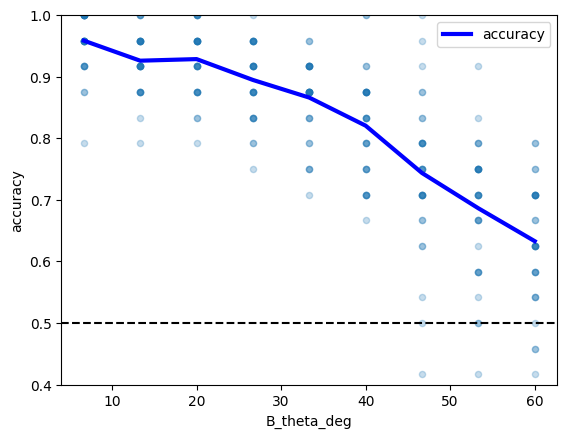

In [29]:
from matplotlib import pyplot as plt
fig, ax = plt.subplots()
results.plot.scatter(x='B_theta_deg', y='accuracy', ax=ax, alpha=.25)
mean_accuracy_per_B_theta = results.groupby('B_theta_deg')['accuracy'].mean().reset_index()
mean_accuracy_per_B_theta.plot(x='B_theta_deg', y='accuracy', ax=ax, color='b', lw=3)
ax.axhline(.5, color='k', linestyle='--')
ax.set_ylim(.4, 1)
mean_accuracy_per_B_theta

In [30]:
from scipy import stats
# stats.ttest_1samp?

In [31]:
for B_theta in results['B_theta_deg'].unique():
    # print(B_theta, results[results['B_theta_deg'] == B_theta]['accuracy'])
    print(B_theta, stats.ttest_1samp(results[results['B_theta_deg'] == B_theta]['accuracy'], popmean=.5))    

6.666666668598186 TtestResult(statistic=53.4593748738681, pvalue=4.2628378162235587e-32, df=31)
13.333333331466793 TtestResult(statistic=48.81631970697917, pvalue=6.902070580224095e-31, df=31)
20.00000000006498 TtestResult(statistic=43.876103402640446, pvalue=1.8010124296530485e-29, df=31)
26.66666666866316 TtestResult(statistic=37.28761056060046, pvalue=2.5492814803450044e-27, df=31)
33.333333331531776 TtestResult(statistic=33.18313664807425, pvalue=8.69333350348154e-26, df=31)
40.00000000012996 TtestResult(statistic=21.49576656682814, pvalue=3.4836135402284136e-20, df=31)
46.66666666872814 TtestResult(statistic=11.280494661471597, pvalue=1.6720344680964163e-12, df=31)
53.333333331596755 TtestResult(statistic=9.855078274438602, pvalue=4.5363792281497676e-11, df=31)
60.00000000019494 TtestResult(statistic=7.8185933402089836, pvalue=8.002781453904252e-09, df=31)


In [32]:
responses = {}

for i_fname, fname in enumerate(filenames_valid):
    session = fname.replace(f'osfstorage-archive/{experiment_name}-', '').replace('-data.json', '')
    df = pd.read_json(fname)
    df_data = df[df['trial_type']=='image-swipe-response'][['trial_index', 'stimulus', 'swipe_response', 'keyboard_response', 'rt', 'response_source']]
    y = np.array(((df_data['swipe_response'] == 'right') + (df_data['keyboard_response'] == 'arrowright')))*1
    responses[session] = y

In [33]:
responses.keys()

dict_keys(['apagrpwbxf', 'w87npww874', '64dtdq27os', 'w2oz9j2a3v', 'wsumnmxd8c', 'rtumbda4hz', 'ybaxemnk16', '6l605rv4nn', 't7vs2ac7eg', '0ck7pzlpvw', '64jgewoyyw', '39dqyx1uj0', 'wtlob6kr2e', 'w18ho6kpvx', 'rxysu10cka', 'bxne598kx7', 'sehsy5603s', 'wcsm8ky6k0', 'yk862o4lsb', 'ghd1a71wdk', 'vc66p7ozf6', 'btnuh2haf5', '84mtaqs5h7', '93ztzrwh11', '2qlee9d9zq', 'fm46nh74sm', 'q0lqucpq2w', 'lxlyu1p2tq', '65r2m7grng', 'u5tbbgfhyx', 'z8n2r64662', 'ck6rohvg0h'])

## one logistic regression per session

https://laurentperrinet.github.io/sciblog/posts/2020-04-08-fitting-a-psychometric-curve-using-pytorch.html

In [34]:
# Best params:  {'batch_size': 12, 'etab1': 0.008772360258447904, 'etab2': 0.00032612851515029934, 'learning_rate': 0.0642067103642039, 'amsgrad': True, 'logit0': -0.9797785718244278, 'log_wt': 0.8596993945366502}
# Best value:  0.06437979997308166

learning_rate = 0.06
etab1, etab2 = 0.01, 0.0003
num_epochs = 2 ** 9 + 1
batch_size = 12
amsgrad = True
logit0 = -1.
log_wt = .85
theta0 = 0.
frozen_theta0 = True

In [80]:
import torch
from torch.utils.data import TensorDataset, DataLoader

# https://pytorch.org/docs/main/generated/torch.nn.BCELoss.html
criterion = torch.nn.BCELoss(reduction="mean")
# https://pytorch.org/docs/main/generated/torch.nn.BCEWithLogitsLoss.html#torch.nn.BCEWithLogitsLoss
criterion = torch.nn.BCEWithLogitsLoss(reduction="mean")

In [ ]:
class LogisticRegressionModel(torch.nn.Module):
    def __init__(self, logit0=logit0, theta0=theta0, log_wt=log_wt, frozen_theta0=False):
        super(LogisticRegressionModel, self).__init__()
        self.theta0 = torch.nn.Parameter(theta0 * torch.ones(1))
        if frozen_theta0: self.theta0.requires_grad = False
        self.logit0 = torch.nn.Parameter(logit0 * torch.ones(1))
        self.log_wt = torch.nn.Parameter(log_wt * torch.ones(1))

    def forward(self, theta):
        p0 = torch.sigmoid(self.logit0)
        out = p0 / 2 + (1 - p0) * torch.sigmoid((theta-self.theta0)/torch.exp(self.log_wt))
        return torch.logit(out)


def fit_data(
    theta,
    y,
    logit0=logit0, theta0=theta0, log_wt=log_wt,
    learning_rate=learning_rate,
    batch_size=batch_size,  
    amsgrad=amsgrad, frozen_theta0=frozen_theta0,
    num_epochs=num_epochs,
    etab1=etab2, etab2=etab2,
    verbose=False
):

    Theta, labels = torch.Tensor(theta[:, None]), torch.Tensor(y[:, None])
    loader = DataLoader(
        TensorDataset(Theta, labels), batch_size=batch_size, shuffle=True
    )

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    logistic_model = LogisticRegressionModel(logit0=logit0, log_wt=log_wt, theta0=theta0, frozen_theta0=frozen_theta0)
    logistic_model = logistic_model.to(device)
    logistic_model.train()
    optimizer = torch.optim.Adam(
        logistic_model.parameters(), lr=learning_rate, betas=(etab1, etab2), amsgrad=amsgrad
    )
    for epoch in range(int(num_epochs)):
        logistic_model.train()
        losses = []
        for Theta_, labels_ in loader:
            Theta_, labels_ = Theta_.to(device), labels_.to(device)
            outputs = logistic_model(Theta_)
            loss = criterion(outputs, labels_)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            losses.append(loss.item())

        if verbose and (epoch % (num_epochs // 32) == 0):
            print(f"Iteration: {epoch} - Loss: {np.sum(losses)/len(theta):.3e}")

    logistic_model.eval()
    outputs = logistic_model(Theta)
    loss = criterion(outputs, labels).item()
    return logistic_model, loss

for apagrpwbxf, training loss = 3.978e-01 - theta0 = -2.218°, p0 = 0.199, slope = 2.337
for w87npww874, training loss = 3.288e-01 - theta0 = -3.284°, p0 = 0.150, slope = 1.662
for 64dtdq27os, training loss = 5.044e-01 - theta0 = 0.871°, p0 = 0.324, slope = 2.781
for w2oz9j2a3v, training loss = 5.020e-01 - theta0 = 5.639°, p0 = 0.325, slope = 2.760
for wsumnmxd8c, training loss = 3.309e-01 - theta0 = 0.633°, p0 = 0.022, slope = 4.742
for rtumbda4hz, training loss = 4.488e-01 - theta0 = 3.576°, p0 = 0.186, slope = 4.204
for ybaxemnk16, training loss = 3.312e-01 - theta0 = -0.258°, p0 = 0.173, slope = 1.185
for 6l605rv4nn, training loss = 5.643e-01 - theta0 = 0.171°, p0 = 0.479, slope = 1.338
for t7vs2ac7eg, training loss = 3.395e-01 - theta0 = 0.992°, p0 = 0.057, slope = 4.199
for 0ck7pzlpvw, training loss = 3.707e-01 - theta0 = -2.010°, p0 = 0.057, slope = 4.808
for 64jgewoyyw, training loss = 3.984e-01 - theta0 = 2.718°, p0 = 0.050, slope = 5.702
for 39dqyx1uj0, training loss = 3.739e-

[Text(0, 0.0, 'CCW'), Text(0, 1.0, 'CW')]

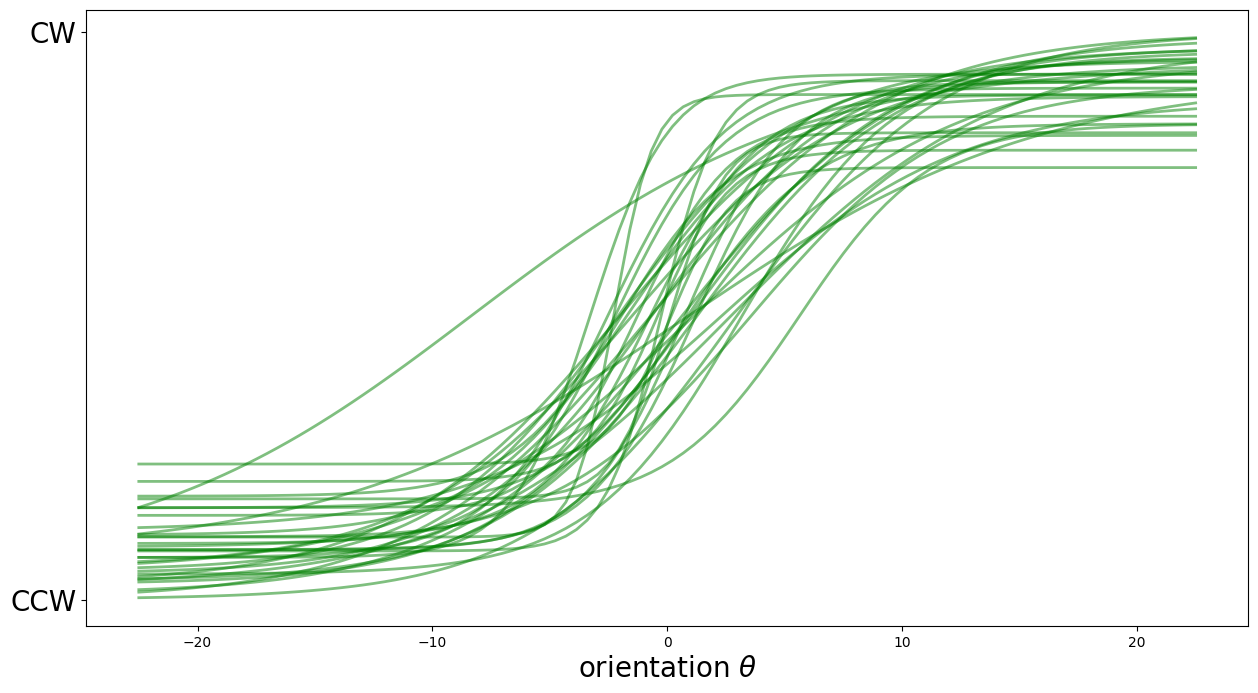

In [37]:
theta_trials = np.array(parameters['theta'])*180/np.pi
theta_max = theta_trials.max()
x_values = np.linspace(-theta_max, theta_max, 100)[:, None]

fig, ax = plt.subplots(figsize=(15, 8))

# for fname in filenames_valid:
#     # shorten the name
#     session = fname.replace(f'osfstorage-archive/{experiment_name}-', '').replace('-data.json', '')
#     # create the dataframe
#     df = pd.read_json(fname)
#     df_data = df[df['trial_type']=='image-swipe-response'][['trial_index', 'stimulus', 'swipe_response', 'keyboard_response', 'rt', 'response_source']]
#     # df_data = df_data.reset_index(drop=True)
#     y = np.array(((df_data['swipe_response'] == 'right') + (df_data['keyboard_response'] == 'arrowright')))*1
for session in responses.keys():    
    y = responses[session]

    logistic_model, loss = fit_data(theta_trials, y, frozen_theta0=False, verbose=False)
    print(f"for {session}, training loss = {loss:.3e} - theta0 = {logistic_model.theta0.item():.3f}°, p0 = {torch.sigmoid(logistic_model.logit0).item():.3f}, slope = {torch.exp(logistic_model.log_wt).item():.3f}")

    y_values = logistic_model(torch.Tensor(x_values)).detach().numpy()
    ax.plot(x_values, y_values, "g", alpha=0.5, lw=2, label=session)

ax.set_xlabel(r"orientation $\theta$", fontsize=20)
ax.set_yticks([0.0, 1.0])
ax.set_yticklabels(["CCW", "CW"], fontsize=20)
# plt.legend(fontsize=20, frameon=False, scatterpoints=6);


for apagrpwbxf, training loss = 4.084e-01 - theta0 = 0.000°, p0 = 0.204, slope = 2.609
for w87npww874, training loss = 3.568e-01 - theta0 = 0.000°, p0 = 0.022, slope = 5.188
for 64dtdq27os, training loss = 5.052e-01 - theta0 = 0.000°, p0 = 0.338, slope = 2.435
for w2oz9j2a3v, training loss = 5.380e-01 - theta0 = 0.000°, p0 = 0.353, slope = 3.878
for wsumnmxd8c, training loss = 3.317e-01 - theta0 = 0.000°, p0 = 0.031, slope = 4.560
for rtumbda4hz, training loss = 4.627e-01 - theta0 = 0.000°, p0 = 0.261, slope = 2.939
for ybaxemnk16, training loss = 3.315e-01 - theta0 = 0.000°, p0 = 0.171, slope = 1.239
for 6l605rv4nn, training loss = 5.643e-01 - theta0 = 0.000°, p0 = 0.480, slope = 1.317
for t7vs2ac7eg, training loss = 3.413e-01 - theta0 = 0.000°, p0 = 0.069, slope = 4.043
for 0ck7pzlpvw, training loss = 3.772e-01 - theta0 = 0.000°, p0 = 0.045, slope = 5.213
for 64jgewoyyw, training loss = 4.085e-01 - theta0 = 0.000°, p0 = 0.100, slope = 4.929
for 39dqyx1uj0, training loss = 3.814e-01 -

[Text(0, 0.0, 'CCW'), Text(0, 1.0, 'CW')]

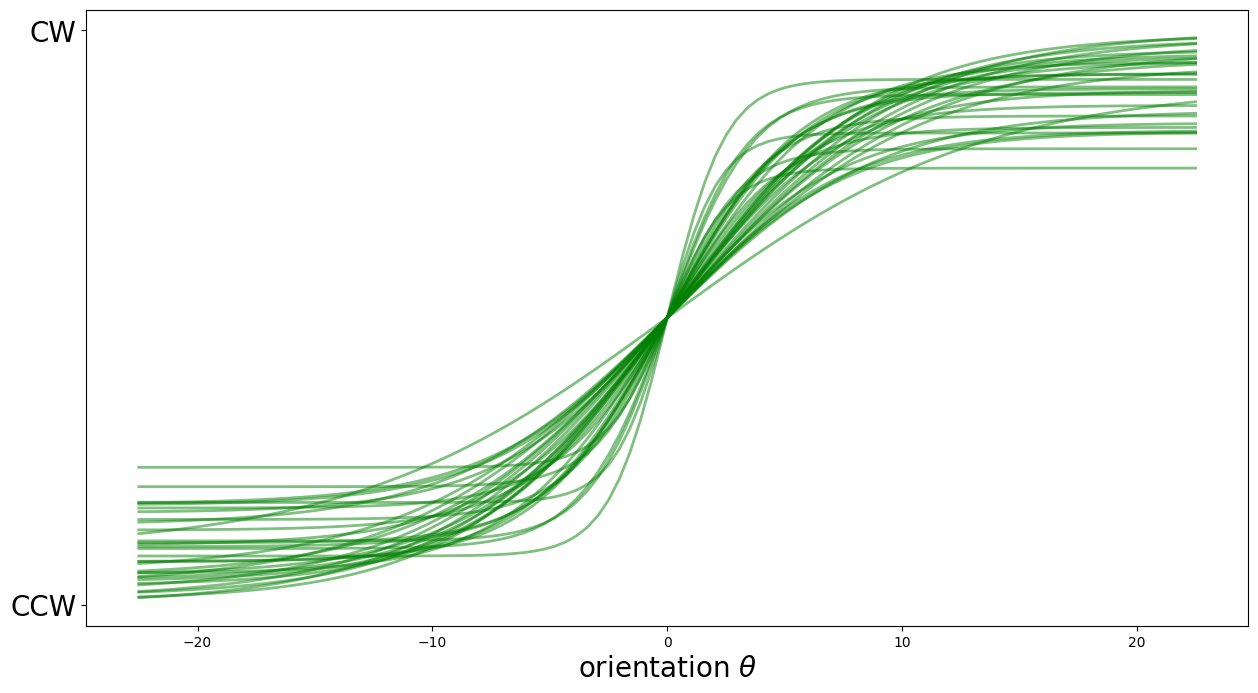

In [38]:
fig, ax = plt.subplots(figsize=(15, 8))

for session in responses.keys():    
    y = responses[session]

    logistic_model, loss = fit_data(theta_trials, y, frozen_theta0=True, verbose=False)
    print(f"for {session}, training loss = {loss:.3e} - theta0 = {logistic_model.theta0.item():.3f}°, p0 = {torch.sigmoid(logistic_model.logit0).item():.3f}, slope = {torch.exp(logistic_model.log_wt).item():.3f}")

    y_values = logistic_model(torch.Tensor(x_values)).detach().numpy()
    ax.plot(x_values, y_values, "g", alpha=0.5, lw=2, label=session)

ax.set_xlabel(r"orientation $\theta$", fontsize=20)
ax.set_yticks([0.0, 1.0])
ax.set_yticklabels(["CCW", "CW"], fontsize=20)
# plt.legend(fontsize=20, frameon=False, scatterpoints=6);


### optimize learning parameters with optuna

In [39]:
logistic_model, loss = fit_data(theta_trials, y, verbose=True)

Iteration: 0 - Loss: 4.512e-02
Iteration: 16 - Loss: 4.456e-02
Iteration: 32 - Loss: 4.451e-02
Iteration: 48 - Loss: 4.455e-02
Iteration: 64 - Loss: 4.452e-02
Iteration: 80 - Loss: 4.453e-02
Iteration: 96 - Loss: 4.453e-02
Iteration: 112 - Loss: 4.453e-02
Iteration: 128 - Loss: 4.454e-02
Iteration: 144 - Loss: 4.453e-02
Iteration: 160 - Loss: 4.451e-02
Iteration: 176 - Loss: 4.453e-02
Iteration: 192 - Loss: 4.450e-02
Iteration: 208 - Loss: 4.452e-02
Iteration: 224 - Loss: 4.451e-02
Iteration: 240 - Loss: 4.454e-02
Iteration: 256 - Loss: 4.455e-02
Iteration: 272 - Loss: 4.451e-02
Iteration: 288 - Loss: 4.452e-02
Iteration: 304 - Loss: 4.453e-02
Iteration: 320 - Loss: 4.450e-02
Iteration: 336 - Loss: 4.451e-02
Iteration: 352 - Loss: 4.449e-02
Iteration: 368 - Loss: 4.450e-02
Iteration: 384 - Loss: 4.451e-02
Iteration: 400 - Loss: 4.452e-02
Iteration: 416 - Loss: 4.458e-02
Iteration: 432 - Loss: 4.453e-02
Iteration: 448 - Loss: 4.454e-02
Iteration: 464 - Loss: 4.451e-02
Iteration: 480 - L

In [40]:
import optuna
optuna.logging.set_verbosity(optuna.logging.WARNING)
path_save_optuna = os.path.join('/tmp', 'optuna.sqlite3') # global name
# %rm {path_save_optuna}


In [41]:
def objective(trial):
    vars = dict(verbose = False,  num_epochs=num_epochs//2)
    max_threshold = .999
    vars['batch_size'] = trial.suggest_int('batch_size', 2, 64, log=True, step=1)
    scale = 4
    vars['etab1'] = trial.suggest_float('etab1', etab1/scale, min(etab1*scale, max_threshold), log=True)
    vars['etab2'] = trial.suggest_float('etab2', etab2/scale, min(etab2*scale, max_threshold), log=True)
    vars['learning_rate'] = trial.suggest_float('learning_rate', learning_rate / scale, learning_rate * scale, log=True)
    vars['amsgrad'] = trial.suggest_categorical('amsgrad', [True, False])
    # initialization
    scale = 2
    vars['logit0'] = trial.suggest_float('logit0', logit0 - scale, logit0 + scale, log=False)
    vars['log_wt'] = trial.suggest_float('log_wt', log_wt - scale, log_wt + scale, log=False)
    # scale = 4
    # vars['theta0'] = trial.suggest_float('theta0', theta0 - scale, theta0 + scale, log=False)

    loss = 0
    for fname in filenames_valid:
        df = pd.read_json(fname)
        df_data = df[df['trial_type']=='image-swipe-response'][['trial_index', 'stimulus', 'swipe_response', 'keyboard_response', 'rt', 'response_source']]
        y = np.array(((df_data['swipe_response'] == 'right') + (df_data['keyboard_response'] == 'arrowright')))*1
        _, loss_ = fit_data(theta, y, **vars)
        loss += loss_
    return loss/len(filenames_valid)


print(50*'=')
sampler = optuna.samplers.TPESampler(multivariate=True)
study = optuna.create_study(direction='minimize', load_if_exists=True, sampler=sampler, storage=f"sqlite:///{path_save_optuna}", study_name='LR')
study.optimize(objective, n_trials=max((200-len(study.trials), 0)), n_jobs=1, show_progress_bar=True)
print(50*'=')

/usr/local/lib/python3.9/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``multivariate`` is an experimental feature. The interface can change in the future.
  warnings.warn(


In [42]:
print(50*'-.')
print("Best params: ", study.best_params)
print("Best value: ", study.best_value)
print(50*'-')


-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.
Best params:  {'batch_size': 12, 'etab1': 0.008772360258447904, 'etab2': 0.00032612851515029934, 'learning_rate': 0.0642067103642039, 'amsgrad': True, 'logit0': -0.9797785718244278, 'log_wt': 0.8596993945366502}
Best value:  0.06437979997308166
--------------------------------------------------


## one logistic regression per session and per B_theta

Some inductive biases:

* the lapse rate is independent of `B_theta`
* the slope is proportional to `B_theta` and should decrease with it

In [43]:
# %whos

In [67]:
learning_rate = 0.001
etab1, etab2 = 0.01, 0.0003
num_epochs = 2 ** 9 + 1
batch_size = 12
amsgrad = True
logit0 = -1.
log_wt = .85
log_wt_B_theta = 1.
theta0 = 0.
frozen_theta0 = True

In [81]:
class LogisticRegressionModel(torch.nn.Module):
    def __init__(self, logit0, theta0, log_wt, log_wt_B_theta, frozen_theta0=False):
        super(LogisticRegressionModel, self).__init__()
        self.theta0 = torch.nn.Parameter(theta0 * torch.ones(1))
        if frozen_theta0: self.theta0.requires_grad = False
        self.logit0 = torch.nn.Parameter(logit0 * torch.ones(1))
        self.log_wt = torch.nn.Parameter(log_wt * torch.ones(1))
        self.log_wt_B_theta = torch.nn.Parameter(log_wt_B_theta * torch.ones(1))

    def forward(self, theta, B_theta):
        p0 = torch.sigmoid(self.logit0)
        out = p0 / 2 + (1 - p0) * torch.sigmoid((theta-self.theta0)/torch.exp(self.log_wt + self.log_wt_B_theta * B_theta))
        return torch.logit(out)

def fit_data_B_theta(
    theta_trials,
    B_theta_trials,
    y,
    logit0=logit0, theta0=theta0, log_wt=log_wt, log_wt_B_theta=log_wt_B_theta, 
    learning_rate=learning_rate,
    batch_size=batch_size,  
    amsgrad=amsgrad, frozen_theta0=frozen_theta0,
    num_epochs=num_epochs,
    etab1=etab2, etab2=etab2,
    verbose=False
):


    theta_trials, B_theta_trials, labels = torch.Tensor(theta_trials[:, None]), torch.Tensor(B_theta_trials[:, None]), torch.Tensor(y[:, None])
    loader = DataLoader(
        TensorDataset(theta_trials, B_theta_trials, labels), batch_size=batch_size, shuffle=True
    )

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    logistic_model = LogisticRegressionModel(logit0=logit0, log_wt=log_wt, log_wt_B_theta=log_wt_B_theta, theta0=theta0, frozen_theta0=frozen_theta0)

    logistic_model = logistic_model.to(device)
    logistic_model.train()
    
    optimizer = torch.optim.Adam(
        logistic_model.parameters(), lr=learning_rate, betas=(etab1, etab2), amsgrad=amsgrad
    )
    for epoch in range(int(num_epochs)):
        logistic_model.train()
        losses = []
        for Theta_, B_theta_, labels_ in loader:
            Theta_, B_theta_, labels_ = Theta_.to(device), B_theta_.to(device), labels_.to(device)

            outputs = logistic_model(Theta_, B_theta_)
            # print(outputs, labels_)
            loss = criterion(outputs, labels_)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            losses.append(loss.item())

        if verbose and (epoch % (num_epochs // 32) == 0):
            print(f"Iteration: {epoch} - Loss: {np.sum(losses)/len(theta_trials):.3e}")

    logistic_model.eval()
    outputs = logistic_model(theta_trials, B_theta_trials)
    loss = criterion(outputs, labels).item()
    return logistic_model, loss

In [82]:
theta_trials = np.array(parameters['theta'])*180/np.pi
theta_max = theta_trials.max()
B_theta_trials = np.array(parameters['B_theta'])*180/np.pi
x_values = np.linspace(-theta_max, theta_max, 100)[:, None]
# Create a colormap
cmap = plt.get_cmap('viridis')
norm = plt.Normalize(vmin=0, vmax=len(B_thetas) - 1)


In [83]:
list(responses.keys())[0]

'apagrpwbxf'

for apagrpwbxf, training loss = 3.450e-01 - theta0 = -0.439°, p0 = 0.075, slope = 0.780, slope_B_theta = 1.051
for w87npww874, training loss = 3.398e-01 - theta0 = -0.879°, p0 = 0.114, slope = 1.026, slope_B_theta = 1.032
for 64dtdq27os, training loss = 4.636e-01 - theta0 = 0.121°, p0 = 0.134, slope = 0.954, slope_B_theta = 1.055
for w2oz9j2a3v, training loss = 4.686e-01 - theta0 = 1.125°, p0 = 0.094, slope = 0.876, slope_B_theta = 1.070
for wsumnmxd8c, training loss = 2.860e-01 - theta0 = -0.188°, p0 = 0.065, slope = 0.812, slope_B_theta = 1.041
for rtumbda4hz, training loss = 4.291e-01 - theta0 = 0.674°, p0 = 0.098, slope = 0.987, slope_B_theta = 1.054
for ybaxemnk16, training loss = 3.037e-01 - theta0 = 0.230°, p0 = 0.082, slope = 0.734, slope_B_theta = 1.043
for 6l605rv4nn, training loss = 4.949e-01 - theta0 = 0.363°, p0 = 0.152, slope = 0.747, slope_B_theta = 1.069
for t7vs2ac7eg, training loss = 2.792e-01 - theta0 = -0.065°, p0 = 0.033, slope = 0.787, slope_B_theta = 1.046
for 0c

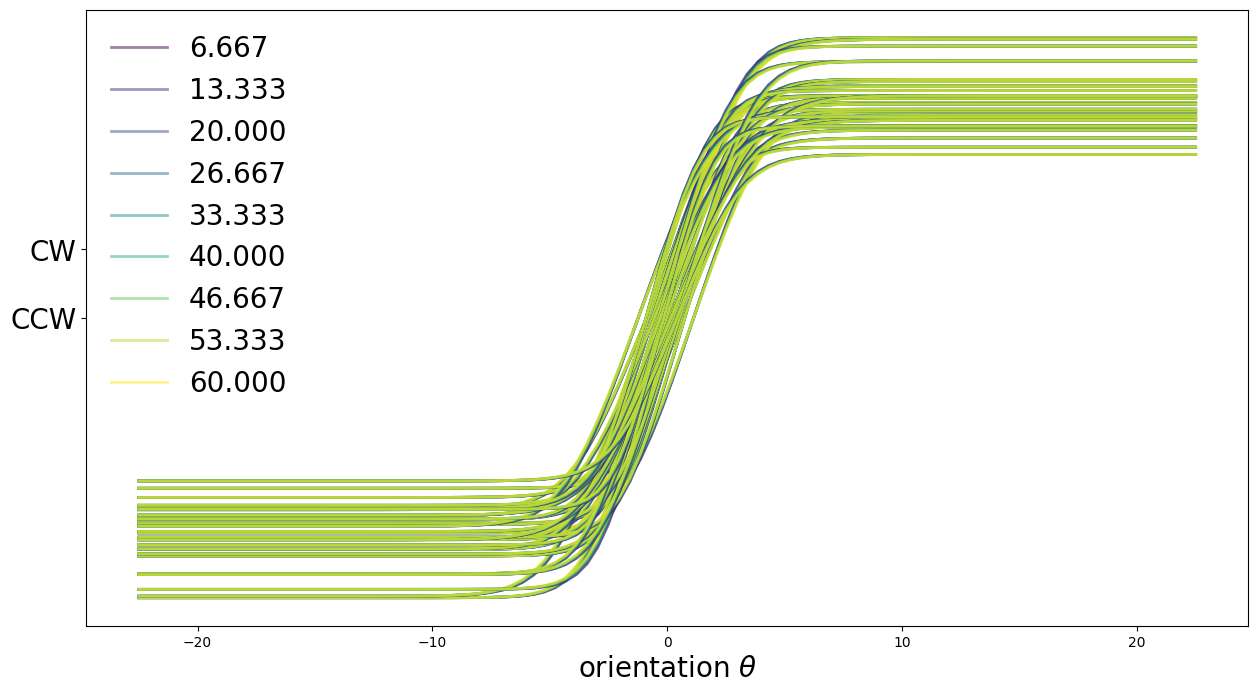

In [84]:
fig, ax = plt.subplots(figsize=(15, 8))
for session in responses.keys():    
    y = responses[session]

    logistic_model, loss = fit_data_B_theta(theta_trials, B_theta_trials, y, frozen_theta0=False, verbose=False)
    
    print(f"for {session}, training loss = {loss:.3e} - theta0 = {logistic_model.theta0.item():.3f}°, p0 = {torch.sigmoid(logistic_model.logit0).item():.3f}, slope = {torch.exp(logistic_model.log_wt).item():.3f}, slope_B_theta = {torch.exp(logistic_model.log_wt_B_theta).item():.3f}")

    for i_B_theta, B_theta in enumerate(B_thetas):
        y_values = logistic_model(torch.Tensor(x_values), B_theta*torch.ones_like(torch.Tensor(x_values))).detach().numpy()
        color = cmap(norm(i_B_theta))
        ax.plot(x_values, y_values, color=color, alpha=0.5, lw=2, label=f'{B_theta*180/np.pi:.3f}' if session==list(responses.keys())[0] else None)

ax.set_xlabel(r"orientation $\theta$", fontsize=20)
ax.set_yticks([0.0, 1.0])
ax.set_yticklabels(["CCW", "CW"], fontsize=20)
plt.legend(fontsize=20, frameon=False, scatterpoints=6);


for apagrpwbxf, training loss = 3.483e-01 - theta0 = 0.000°, p0 = 0.078, slope = 0.787, slope_B_theta = 1.051
for w87npww874, training loss = 3.539e-01 - theta0 = 0.000°, p0 = 0.115, slope = 1.085, slope_B_theta = 1.032
for 64dtdq27os, training loss = 4.638e-01 - theta0 = 0.000°, p0 = 0.131, slope = 0.955, slope_B_theta = 1.056
for w2oz9j2a3v, training loss = 4.810e-01 - theta0 = 0.000°, p0 = 0.099, slope = 0.905, slope_B_theta = 1.070
for wsumnmxd8c, training loss = 2.861e-01 - theta0 = 0.000°, p0 = 0.062, slope = 0.809, slope_B_theta = 1.041
for rtumbda4hz, training loss = 4.340e-01 - theta0 = 0.000°, p0 = 0.099, slope = 0.970, slope_B_theta = 1.055
for ybaxemnk16, training loss = 3.047e-01 - theta0 = 0.000°, p0 = 0.085, slope = 0.744, slope_B_theta = 1.042
for 6l605rv4nn, training loss = 4.960e-01 - theta0 = 0.000°, p0 = 0.152, slope = 0.750, slope_B_theta = 1.069
for t7vs2ac7eg, training loss = 2.818e-01 - theta0 = 0.000°, p0 = 0.043, slope = 0.803, slope_B_theta = 1.045
for 0ck7pz

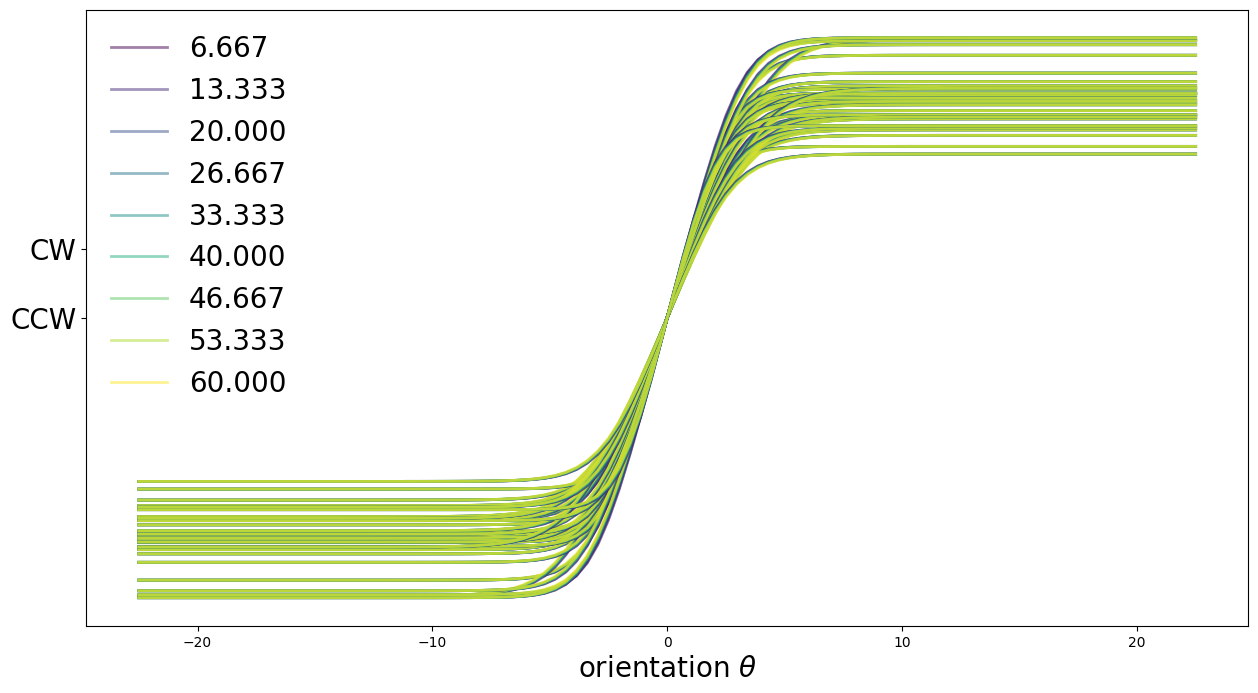

In [85]:
fig, ax = plt.subplots(figsize=(15, 8))
for session in responses.keys():    
    y = responses[session]
    logistic_model, loss = fit_data_B_theta(theta_trials, B_theta_trials, y, frozen_theta0=True, verbose=False)
    print(f"for {session}, training loss = {loss:.3e} - theta0 = {logistic_model.theta0.item():.3f}°, p0 = {torch.sigmoid(logistic_model.logit0).item():.3f}, slope = {torch.exp(logistic_model.log_wt).item():.3f}, slope_B_theta = {torch.exp(logistic_model.log_wt_B_theta).item():.3f}")

    for i_B_theta, B_theta in enumerate(B_thetas):
        y_values = logistic_model(torch.Tensor(x_values), B_theta*torch.ones_like(torch.Tensor(x_values))).detach().numpy()
        color = cmap(norm(i_B_theta))
        ax.plot(x_values, y_values, color=color, alpha=0.5, lw=2, label=f'{B_theta*180/np.pi:.3f}' if session==list(responses.keys())[0] else None)

ax.set_xlabel(r"orientation $\theta$", fontsize=20)
ax.set_yticks([0.0, 1.0])
ax.set_yticklabels(["CCW", "CW"], fontsize=20)
plt.legend(fontsize=20, frameon=False, scatterpoints=6);


### optimize learning parameters with optuna

In [86]:
logistic_model, loss = fit_data_B_theta(theta_trials, B_theta_trials, y, verbose=True)

Iteration: 0 - Loss: 5.774e-02
Iteration: 16 - Loss: 5.772e-02
Iteration: 32 - Loss: 5.768e-02
Iteration: 48 - Loss: 5.759e-02
Iteration: 64 - Loss: 5.743e-02
Iteration: 80 - Loss: 5.713e-02
Iteration: 96 - Loss: 5.664e-02
Iteration: 112 - Loss: 5.576e-02
Iteration: 128 - Loss: 5.394e-02
Iteration: 144 - Loss: 5.004e-02
Iteration: 160 - Loss: 3.866e-02
Iteration: 176 - Loss: 3.821e-02
Iteration: 192 - Loss: 3.816e-02
Iteration: 208 - Loss: 3.811e-02
Iteration: 224 - Loss: 3.808e-02
Iteration: 240 - Loss: 3.805e-02
Iteration: 256 - Loss: 3.802e-02
Iteration: 272 - Loss: 3.799e-02
Iteration: 288 - Loss: 3.797e-02
Iteration: 304 - Loss: 3.794e-02
Iteration: 320 - Loss: 3.793e-02
Iteration: 336 - Loss: 3.790e-02
Iteration: 352 - Loss: 3.787e-02
Iteration: 368 - Loss: 3.785e-02
Iteration: 384 - Loss: 3.783e-02
Iteration: 400 - Loss: 3.781e-02
Iteration: 416 - Loss: 3.778e-02
Iteration: 432 - Loss: 3.777e-02
Iteration: 448 - Loss: 3.775e-02
Iteration: 464 - Loss: 3.773e-02
Iteration: 480 - L

In [87]:
import optuna
optuna.logging.set_verbosity(optuna.logging.WARNING)
path_save_optuna = os.path.join('/tmp', 'B_theta_optuna.sqlite3') # global name
# %rm {path_save_optuna}

In [88]:
def objective(trial):
    vars = dict(verbose = False,  num_epochs=num_epochs//2)
    max_threshold = .999
    vars['batch_size'] = trial.suggest_int('batch_size', 2, 64, log=True, step=1)
    scale = 10
    vars['log_wt_B_theta'] = trial.suggest_float('log_wt_B_theta', log_wt - scale, log_wt + scale, log=False)
    scale = 4
    vars['etab1'] = trial.suggest_float('etab1', etab1/scale, min(etab1*scale, max_threshold), log=True)
    vars['etab2'] = trial.suggest_float('etab2', etab2/scale, min(etab2*scale, max_threshold), log=True)
    vars['learning_rate'] = trial.suggest_float('learning_rate', learning_rate / scale, learning_rate * scale, log=True)
    vars['amsgrad'] = trial.suggest_categorical('amsgrad', [True, False])
    # initialization
    scale = 2
    vars['logit0'] = trial.suggest_float('logit0', logit0 - scale, logit0 + scale, log=False)
    vars['log_wt'] = trial.suggest_float('log_wt', log_wt - scale, log_wt + scale, log=False)
    # vars['theta0'] = trial.suggest_float('theta0', theta0 - scale, theta0 + scale, log=False)

    loss = 0
    for fname in filenames_valid:
        df = pd.read_json(fname)
        df_data = df[df['trial_type']=='image-swipe-response'][['trial_index', 'stimulus', 'swipe_response', 'keyboard_response', 'rt', 'response_source']]
        y = np.array(((df_data['swipe_response'] == 'right') + (df_data['keyboard_response'] == 'arrowright')))*1
        _, loss_ = fit_data_B_theta(theta_trials, B_theta_trials, y, **vars)
        loss += loss_
    return loss/len(filenames_valid)


print(50*'=')
sampler = optuna.samplers.TPESampler(multivariate=True)
study = optuna.create_study(direction='minimize', load_if_exists=True, sampler=sampler, storage=f"sqlite:///{path_save_optuna}", study_name='LR')
study.optimize(objective, n_trials=max((200-len(study.trials), 0)), n_jobs=1, show_progress_bar=True)
print(50*'=')

/usr/local/lib/python3.9/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``multivariate`` is an experimental feature. The interface can change in the future.
  warnings.warn(


  0%|          | 0/199 [00:00<?, ?it/s]

[W 2025-03-15 11:21:36,821] Trial 1 failed with parameters: {'batch_size': 15, 'log_wt_B_theta': 4.512583866671553, 'etab1': 0.003878645092848631, 'etab2': 0.000467748365735661, 'learning_rate': 0.002092307812951931, 'amsgrad': False, 'logit0': -0.6869397658850298, 'log_wt': 2.536496033942861} because of the following error: The value nan is not acceptable.
[W 2025-03-15 11:21:36,822] Trial 1 failed with value nan.
[W 2025-03-15 11:23:26,509] Trial 2 failed with parameters: {'batch_size': 19, 'log_wt_B_theta': -4.075927731625004, 'etab1': 0.004102903927050828, 'etab2': 0.0007684785758997135, 'learning_rate': 0.0033701670159984494, 'amsgrad': False, 'logit0': 0.6871145280121715, 'log_wt': 0.0855763732673327} because of the following error: The value nan is not acceptable.
[W 2025-03-15 11:23:26,511] Trial 2 failed with value nan.
[W 2025-03-15 11:34:37,750] Trial 3 failed with parameters: {'batch_size': 2, 'log_wt_B_theta': 8.856013264346986, 'etab1': 0.01114327090118426, 'etab2': 0.000

In [89]:
print(50*'-.')
print("Best params: ", study.best_params)
print("Best value: ", study.best_value)
print(50*'-')


-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.
Best params:  {'batch_size': 8, 'log_wt_B_theta': 0.1747629524207639, 'etab1': 0.02908051731288224, 'etab2': 0.00037561268412693484, 'learning_rate': 0.0039032702067908456, 'amsgrad': True, 'logit0': -2.4752605567001558, 'log_wt': 0.14994929375493915}
Best value:  0.3697289675474167
--------------------------------------------------
